In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import string
from tqdm import tqdm_notebook as tqdm

from gensim.models import *

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import *
import keras.backend as K
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

/home/bharaj/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [33]:
### READ DATA ###

df = pd.read_csv('whole_mal.tsv',sep='\t',names=['category','text'])

print(df.shape)
df.head()

(6739, 2)


,category,text
0,unknown state,Ichayan fans pinne mmade ettan fansm ivde oru...
1,not-malayalam,Tovi 🥰 Best Wishes From #Kunjikka Fans
2,unknown state,Urutty koll .nallavanaaya unniyaya saiju kuru...
3,not-malayalam,Pls support me pls My channel subscribe...
4,Positive,Kalki super hit akum enn Bonny parayan paranju


In [34]:
### LABEL DISTRIBUTION ###

df.category.value_counts().plot.pie(figsize=(6,6))

In [35]:
### SIMPLE CLEAN OF TEXT ###

df['text'] = df.text.str.lower().str.replace(r'['+string.digits+string.punctuation+']', ' ')
df['text'] = df['text'].apply(lambda x: x.split())

In [36]:
### SPLIT INTO TRAIN/TEST ###

y = np_utils.to_categorical(df.category.factorize()[0])

X_train, X_test, y_train, y_test = train_test_split(df['text'].tolist(), y, random_state=33, test_size=0.2)

In [37]:
y

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [38]:
print(X_train[0],y[0])

['trailer', 'bore', 'aayi', 'eni', 'movie', 'kandu', 'nokkam'] [1. 0. 0. 0. 0.]


In [39]:
### MAP LABEL ###

diz_label = {}
for i,label in enumerate(df.category.factorize()[1]):
    diz_label[i] = label
    
diz_label

{0: 'unknown state ',
 1: 'not-malayalam ',
 2: 'Positive ',
 3: 'Negative ',
 4: 'Mixed feelings '}

In [40]:
### TRAIN WORD2VEC AND FASTTEXT ###

w2v = Word2Vec(size=100, window=5, min_count=4, seed=33)
w2v.build_vocab(X_train)
w2v.train(X_train, total_examples=w2v.corpus_count, epochs=10)

ft = FastText(size=100, window=5, min_count=4, seed=33)
ft.build_vocab(X_train)
ft.train(X_train, total_examples=ft.corpus_count, epochs=10)

In [41]:
### TRANSFORM ORIGINAL TEXT INTO SEQUENCES AND COMPUTE PADDING ###

max_len = 200

tokenizer = Tokenizer(lower=True, split='')
tokenizer.fit_on_texts(X_train)

sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_train = pad_sequences(sequence_train, maxlen=max_len)

sequence_test = tokenizer.texts_to_sequences(X_test)
sequence_test = pad_sequences(sequence_test, maxlen=max_len)

sequence_train = np.asarray(sequence_train)
sequence_test = np.asarray(sequence_test)

print(sequence_train.shape, sequence_test.shape)

(5391, 200) (1348, 200)


In [42]:
### GET TRAINED WEIGHTS FOR EACH WORD FROM WORD2VEC ###

embedding_matrix_w2v = np.random.random((len(tokenizer.word_index) + 1, 100))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_w2v[i] = w2v.wv[word]
    except:
        pas+=1
        
print('not in vocabulary', pas)

not in vocabulary 12245


In [43]:
### GET TRAINED WEIGHTS FOR EACH WORD FROM FASTTEXT ###

embedding_matrix_ft = np.random.random((len(tokenizer.word_index) + 1, 100))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_ft[i] = ft.wv[word]
    except:
        pas+=1
        
print('not in vocabulary', pas)

not in vocabulary 0


In [44]:
### DEFINE INPUT LAYER FOR EMBEDDINGS READING AND CONCATENATION ###

def Concat_Emb(list_emb, maxlen):
    
    inputs = []
    output = []
    for embedding in list_emb:
        
        inp = Input(shape=(maxlen,))
        emb = Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding], trainable=False)(inp)
        emb = Reshape((-1,100,1))(emb)
        inputs.append(inp)
        output.append(emb)
        
    concat = Concatenate(axis=-1)(output)
    
    return Model(inputs, concat)

In [45]:
### TRY Concat_Emb ###

read_emb = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
read_emb.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 200, 100)     1378400     input_9[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 200, 100)     1378400     input_10[0][0]                   
__________________________________________________________________________________________________
reshape_11

In [46]:
### DEFINE DME AND CDME BLOCKS ###

def DME(maxlen):

    inp = Input(shape=(maxlen, 100, 2))
    x = Reshape((maxlen, -1))(inp)
    x = LSTM(2, return_sequences=True)(x)
    x = Activation('sigmoid')(x)
    x = Reshape((maxlen, 1, 2))(x)
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    
    return Model(inp, out)

def CDME(maxlen, latent_dim=2):
    
    inp = Input(shape=(maxlen, 100, 2))
    x = Reshape((maxlen, -1))(inp)
    x = Bidirectional(LSTM(latent_dim, return_sequences=True))(x)
    x = Lambda(lambda t: [t[:,:,:int(latent_dim/2+1)], t[:,:,int(latent_dim/2+1):]])(x)
    x = Maximum()(x)
    x = Activation('sigmoid')(x)
    x = Reshape((maxlen, 1, 2))(x)
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    
    return Model(inp, out)

In [47]:
### DEFINE NETWORK WITH DME ###

concat_inp = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
dme = DME(max_len)
x = dme(concat_inp.output)
x = GRU(128, dropout=0.2, return_sequences=True)(x)
x = GRU(32, dropout=0.2)(x)
out = Dense(y.shape[1], activation='softmax')(x)

dme_model = Model(concat_inp.input, out)
dme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

dme_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 200, 100)     1378400     input_11[0][0]                   
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 200, 100)     1378400     input_12[0][0]                   
__________________________________________________________________________________________________
reshape_13

In [48]:
dme_model.fit([sequence_train]*2, y_train, batch_size=128, epochs=20, verbose=2, validation_split=0.1)

Train on 4851 samples, validate on 540 samples
Epoch 1/20
 - 46s - loss: 1.3953 - acc: 0.3974 - val_loss: 1.3517 - val_acc: 0.4667
Epoch 2/20
 - 41s - loss: 1.3348 - acc: 0.4341 - val_loss: 1.2882 - val_acc: 0.5019
Epoch 3/20
 - 41s - loss: 1.2954 - acc: 0.4663 - val_loss: 1.2354 - val_acc: 0.5315
Epoch 4/20
 - 41s - loss: 1.2640 - acc: 0.4884 - val_loss: 1.1858 - val_acc: 0.5352
Epoch 5/20
 - 40s - loss: 1.2367 - acc: 0.4976 - val_loss: 1.1766 - val_acc: 0.5500
Epoch 6/20
 - 41s - loss: 1.2243 - acc: 0.5042 - val_loss: 1.1625 - val_acc: 0.5481
Epoch 7/20
 - 40s - loss: 1.2103 - acc: 0.5077 - val_loss: 1.1524 - val_acc: 0.5519
Epoch 8/20
 - 41s - loss: 1.1918 - acc: 0.5182 - val_loss: 1.1528 - val_acc: 0.5481
Epoch 9/20
 - 40s - loss: 1.1776 - acc: 0.5213 - val_loss: 1.1287 - val_acc: 0.5648
Epoch 10/20
 - 40s - loss: 1.1596 - acc: 0.5430 - val_loss: 1.1200 - val_acc: 0.5463
Epoch 11/20
 - 40s - loss: 1.1443 - acc: 0.5442 - val_loss: 1.0926 - val_acc: 0.5574
Epoch 12/20
 - 40s - loss: 

In [49]:
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                            [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)]))

                 precision    recall  f1-score   support

Mixed feelings        0.00      0.00      0.00        73
      Negative        0.63      0.08      0.14       148
      Positive        0.55      0.86      0.67       559
 not-malayalam        0.64      0.42      0.51       185
 unknown state        0.56      0.48      0.52       383

      micro avg       0.56      0.56      0.56      1348
      macro avg       0.48      0.37      0.37      1348
   weighted avg       0.54      0.56      0.51      1348



/home/bharaj/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


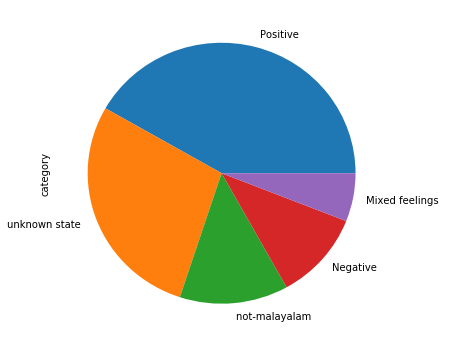

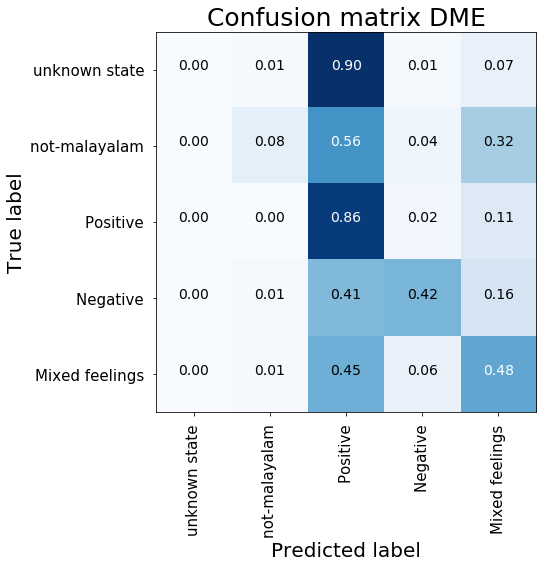

In [50]:
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix DME")
plt.show()

In [51]:
### DEFINE NETWORK WITH CDME ###

concat_inp = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
cdme = CDME(max_len)
x = cdme(concat_inp.output)
x = GRU(128, dropout=0.2, return_sequences=True)(x)
x = GRU(32, dropout=0.2)(x)
out = Dense(y.shape[1], activation='softmax')(x)

cdme_model = Model(concat_inp.input, out)
cdme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cdme_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 200, 100)     1378400     input_14[0][0]                   
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 200, 100)     1378400     input_15[0][0]                   
__________________________________________________________________________________________________
reshape_17

In [52]:
cdme_model.fit([sequence_train]*2, y_train, batch_size=128, epochs=20, verbose=2, validation_split=0.1)

Train on 4851 samples, validate on 540 samples
Epoch 1/20
 - 60s - loss: 1.3915 - acc: 0.4148 - val_loss: 1.3352 - val_acc: 0.4611
Epoch 2/20
 - 53s - loss: 1.3334 - acc: 0.4397 - val_loss: 1.2798 - val_acc: 0.5019
Epoch 3/20
 - 53s - loss: 1.2973 - acc: 0.4677 - val_loss: 1.2442 - val_acc: 0.5074
Epoch 4/20
 - 52s - loss: 1.2592 - acc: 0.4906 - val_loss: 1.2000 - val_acc: 0.5204
Epoch 5/20
 - 53s - loss: 1.2497 - acc: 0.4972 - val_loss: 1.1786 - val_acc: 0.5333
Epoch 6/20
 - 52s - loss: 1.2293 - acc: 0.5030 - val_loss: 1.1839 - val_acc: 0.5389
Epoch 7/20
 - 52s - loss: 1.2067 - acc: 0.5133 - val_loss: 1.1493 - val_acc: 0.5444
Epoch 8/20
 - 53s - loss: 1.1954 - acc: 0.5213 - val_loss: 1.1518 - val_acc: 0.5611
Epoch 9/20
 - 52s - loss: 1.1694 - acc: 0.5337 - val_loss: 1.1244 - val_acc: 0.5463
Epoch 10/20
 - 53s - loss: 1.1676 - acc: 0.5354 - val_loss: 1.1266 - val_acc: 0.5463
Epoch 11/20
 - 52s - loss: 1.1594 - acc: 0.5368 - val_loss: 1.1031 - val_acc: 0.5685
Epoch 12/20
 - 53s - loss: 

In [53]:
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                            [diz_label[i] for i in np.argmax(cdme_model.predict([sequence_test]*2), axis=1)]))

                 precision    recall  f1-score   support

Mixed feelings        0.00      0.00      0.00        73
      Negative        0.55      0.11      0.18       148
      Positive        0.56      0.85      0.67       559
 not-malayalam        0.57      0.43      0.49       185
 unknown state        0.57      0.48      0.52       383

      micro avg       0.56      0.56      0.56      1348
      macro avg       0.45      0.37      0.37      1348
   weighted avg       0.53      0.56      0.51      1348



/home/bharaj/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


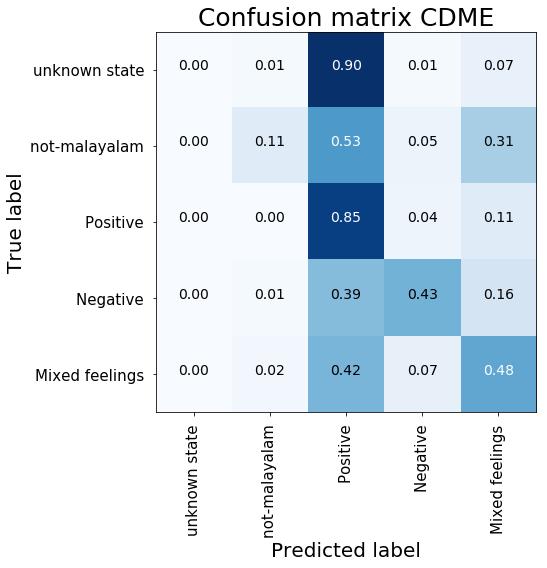

In [54]:
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(cdme_model.predict([sequence_test]*2), axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix CDME")
plt.show()